# Example training script

In [37]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

from jeans_gnn import utils
from jeans_gnn import density_sampler

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/mplstyle/latex_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_name = 'mini_gNFW_Plummer_OM_poisson100'
dataset_dirpath = utils.paths.find_dataset(dataset_name)

dataset_path = os.path.join(dataset_dirpath, 'train.hdf5')
node_features, graph_features, headers = utils.dataset.read_graph_dataset(
    dataset_path)

# print all headers
for k, v in headers.items():
    print('{}: {}'.format(k, v))

all_features: ['pos' 'vel' 'vel_error' 'dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm'
 'dm_rho_0' 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
dataset_name: mini_gNFW_Plummer_OM_poisson100
date: 2023-04-14 11:23:34
df_type: QuasiSpherical
dm_type: Spheroid
error_los: 0
flag: train
galaxy_name: mini_gNFW_Plummer_OM_poisson100
graph_features: ['dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm' 'dm_rho_0'
 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
labels_order: ['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
name: mini
node_features: ['pos' 'vel' 'vel_error']
num_galaxies: 900
projection: 0
stellar_type: Plummer
train_frac: 0.9


In [4]:
def get_graph(node_features, graph_features, idx):
    """ Get a graph from the dataset given the index """
    nodes = {}
    for k, v in node_features.items():
        nodes[k] = v[idx]
    graph = {}
    for k, v in graph_features.items():
        graph[k] = v[idx]
    return nodes, graph

In [5]:
# get and plot an example graph
idx = 0
nodes, graph = get_graph(node_features, graph_features, idx)
pos = nodes['pos']  # 2d positions
vel = nodes['vel']  # los velocity

# print labels of the graph
print(headers['labels_order'])
print(graph['labels'])

['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
[ 1.30011868 -0.90858969  7.17224876 -1.57692468  0.49082216 -1.78850213]


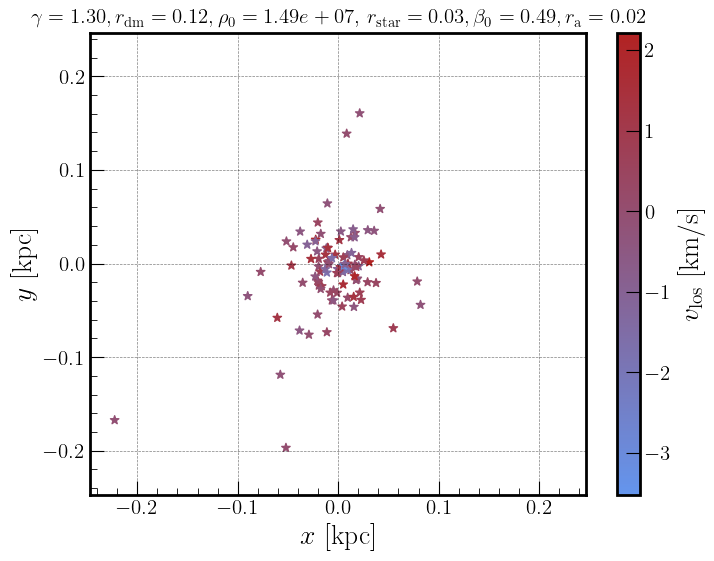

In [6]:
# plot the 2d positions colored by the line-of-sight velocity
fig, ax = plt.subplots(1, figsize=(8, 6))

# plot options
s = 40
marker = '*'
box_size = 2 * 10**graph['labels'][1]
# create a colormap by adding gradients between colors
color1 = 'cornflowerblue'
color2 = 'firebrick'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])
# set title to be parameters gamma, r_dm, rho_0, r_star, beta_0, r_a
title = r'$\gamma={:.2f}, r_{{\rm dm}}={:.2f}, \rho_0={:.2e}$, '\
    r'$r_{{\rm star}}={:.2f}, \beta_0={:.2f}, r_{{\rm a}}={:.2f}$'.format(
    graph['labels'][0], 10**graph['labels'][1], 10**graph['labels'][2], 
    10**graph['labels'][3], graph['labels'][4], 10**graph['labels'][5])

# create a log scale for the colorbar
norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

# plot the nodes
sc = ax.scatter(pos[:, 0], pos[:, 1], c=vel, norm=norm, s=s, 
                marker=marker, cmap=cmap)
ax.set_xlim(-box_size, box_size)
ax.set_ylim(-box_size, box_size)

# add labels
ax.set_xlabel(r'$x$ [kpc]', fontsize=20)  
ax.set_ylabel(r'$y$ [kpc]', fontsize=20)
ax.set_title(title, fontsize=15)

# add a colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$v_{\rm los}$ [km/s]', fontsize=20)

# add major grid and minor ticks
ax.grid(which='major', linestyle='--', linewidth='0.5', 
        alpha=0.5, color='black')
ax.minorticks_on()

plt.show()

## Training

In [23]:
sampler = density_sampler.DensitySampler(
    run_name='test', config_file='test.yaml')
sampler.fit(
    dataset_name=dataset_name, 
    batch_size=128,
    num_workers=1,
    max_epochs=1000,
    patience=40, 
    save_top_k=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | GraphRegressor | 441 K 
-----------------------------------------
441 K     Trainable params
0         Non-trainable params
441 K     Total params
1.765     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 12.05it/s, loss=14.9, v_num=]

Metric val_loss improved. New best score: 14.575


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 12.43it/s, loss=14.4, v_num=]

Metric val_loss improved by 0.576 >= min_delta = 0.0. New best score: 13.999


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 10.72it/s, loss=13.9, v_num=]

Metric val_loss improved by 1.132 >= min_delta = 0.0. New best score: 12.867


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 12.03it/s, loss=13.2, v_num=]

Metric val_loss improved by 0.850 >= min_delta = 0.0. New best score: 12.016


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 12.72it/s, loss=12.5, v_num=]

Metric val_loss improved by 1.201 >= min_delta = 0.0. New best score: 10.816


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 13.97it/s, loss=11.6, v_num=]

Metric val_loss improved by 0.878 >= min_delta = 0.0. New best score: 9.938


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 12.22it/s, loss=10.9, v_num=]

Metric val_loss improved by 1.747 >= min_delta = 0.0. New best score: 8.191


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 13.36it/s, loss=9.95, v_num=]

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 8.046


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 12.04it/s, loss=9.12, v_num=]

Metric val_loss improved by 1.117 >= min_delta = 0.0. New best score: 6.929


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 12.56it/s, loss=8.15, v_num=]

Metric val_loss improved by 0.568 >= min_delta = 0.0. New best score: 6.361


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 12.16it/s, loss=7.55, v_num=]

Metric val_loss improved by 0.684 >= min_delta = 0.0. New best score: 5.677


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 12.19it/s, loss=6.93, v_num=]

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 5.519


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 12.20it/s, loss=6.3, v_num=] 

Metric val_loss improved by 0.746 >= min_delta = 0.0. New best score: 4.773


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 12.07it/s, loss=5.47, v_num=]

Metric val_loss improved by 0.891 >= min_delta = 0.0. New best score: 3.882


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 12.48it/s, loss=4.55, v_num=]

Metric val_loss improved by 0.540 >= min_delta = 0.0. New best score: 3.342


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 11.62it/s, loss=3.96, v_num=]

Metric val_loss improved by 0.823 >= min_delta = 0.0. New best score: 2.520


Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 11.78it/s, loss=3.85, v_num=]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 2.449


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 12.04it/s, loss=3.48, v_num=]

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 2.252


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 11.71it/s, loss=2.96, v_num=]

Metric val_loss improved by 0.311 >= min_delta = 0.0. New best score: 1.940


Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 12.10it/s, loss=2.81, v_num=]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.933


Epoch 31: 100%|██████████| 9/9 [00:00<00:00, 11.98it/s, loss=2.78, v_num=]

Metric val_loss improved by 0.525 >= min_delta = 0.0. New best score: 1.408


Epoch 33: 100%|██████████| 9/9 [00:00<00:00, 12.29it/s, loss=1.97, v_num=]

Metric val_loss improved by 0.294 >= min_delta = 0.0. New best score: 1.113


Epoch 34: 100%|██████████| 9/9 [00:00<00:00, 12.07it/s, loss=1.72, v_num=]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.077


Epoch 35: 100%|██████████| 9/9 [00:00<00:00, 11.70it/s, loss=1.61, v_num=]

Metric val_loss improved by 0.380 >= min_delta = 0.0. New best score: 0.697


Epoch 36: 100%|██████████| 9/9 [00:00<00:00, 12.67it/s, loss=1.55, v_num=]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.654


Epoch 49: 100%|██████████| 9/9 [00:00<00:00, 11.01it/s, loss=1.01, v_num=] 

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 0.511


Epoch 51: 100%|██████████| 9/9 [00:00<00:00, 11.80it/s, loss=0.99, v_num=] 

Metric val_loss improved by 0.519 >= min_delta = 0.0. New best score: -0.008


Epoch 63: 100%|██████████| 9/9 [00:00<00:00, 12.41it/s, loss=0.509, v_num=]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: -0.124


Epoch 64: 100%|██████████| 9/9 [00:00<00:00, 11.65it/s, loss=0.393, v_num=]

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: -0.299


Epoch 104: 100%|██████████| 9/9 [00:00<00:00, 13.62it/s, loss=0.568, v_num=] 

Monitored metric val_loss did not improve in the last 40 records. Best score: -0.299. Signaling Trainer to stop.


Epoch 104: 100%|██████████| 9/9 [00:00<00:00, 13.04it/s, loss=0.568, v_num=]


In [30]:
val_loader = utils.dataset.create_dataloader(
    dataset_name=dataset_name, flag='valid',
    transform=sampler.transform, batch_size=128, num_workers=1
)

In [68]:
posteriors = []
truths = []
with torch.no_grad():
    sampler.model.eval()
    for batch in val_loader:
        x = sampler.model.sample(batch, 10000)
        posteriors.append(x.detach().cpu().numpy())
        truths.append(batch.y.detach().cpu().numpy())
posteriors = np.concatenate(posteriors, axis=0)
truths = np.concatenate(truths, axis=0)

In [47]:
import corner

In [83]:
truths[7, 0]

0.7269873

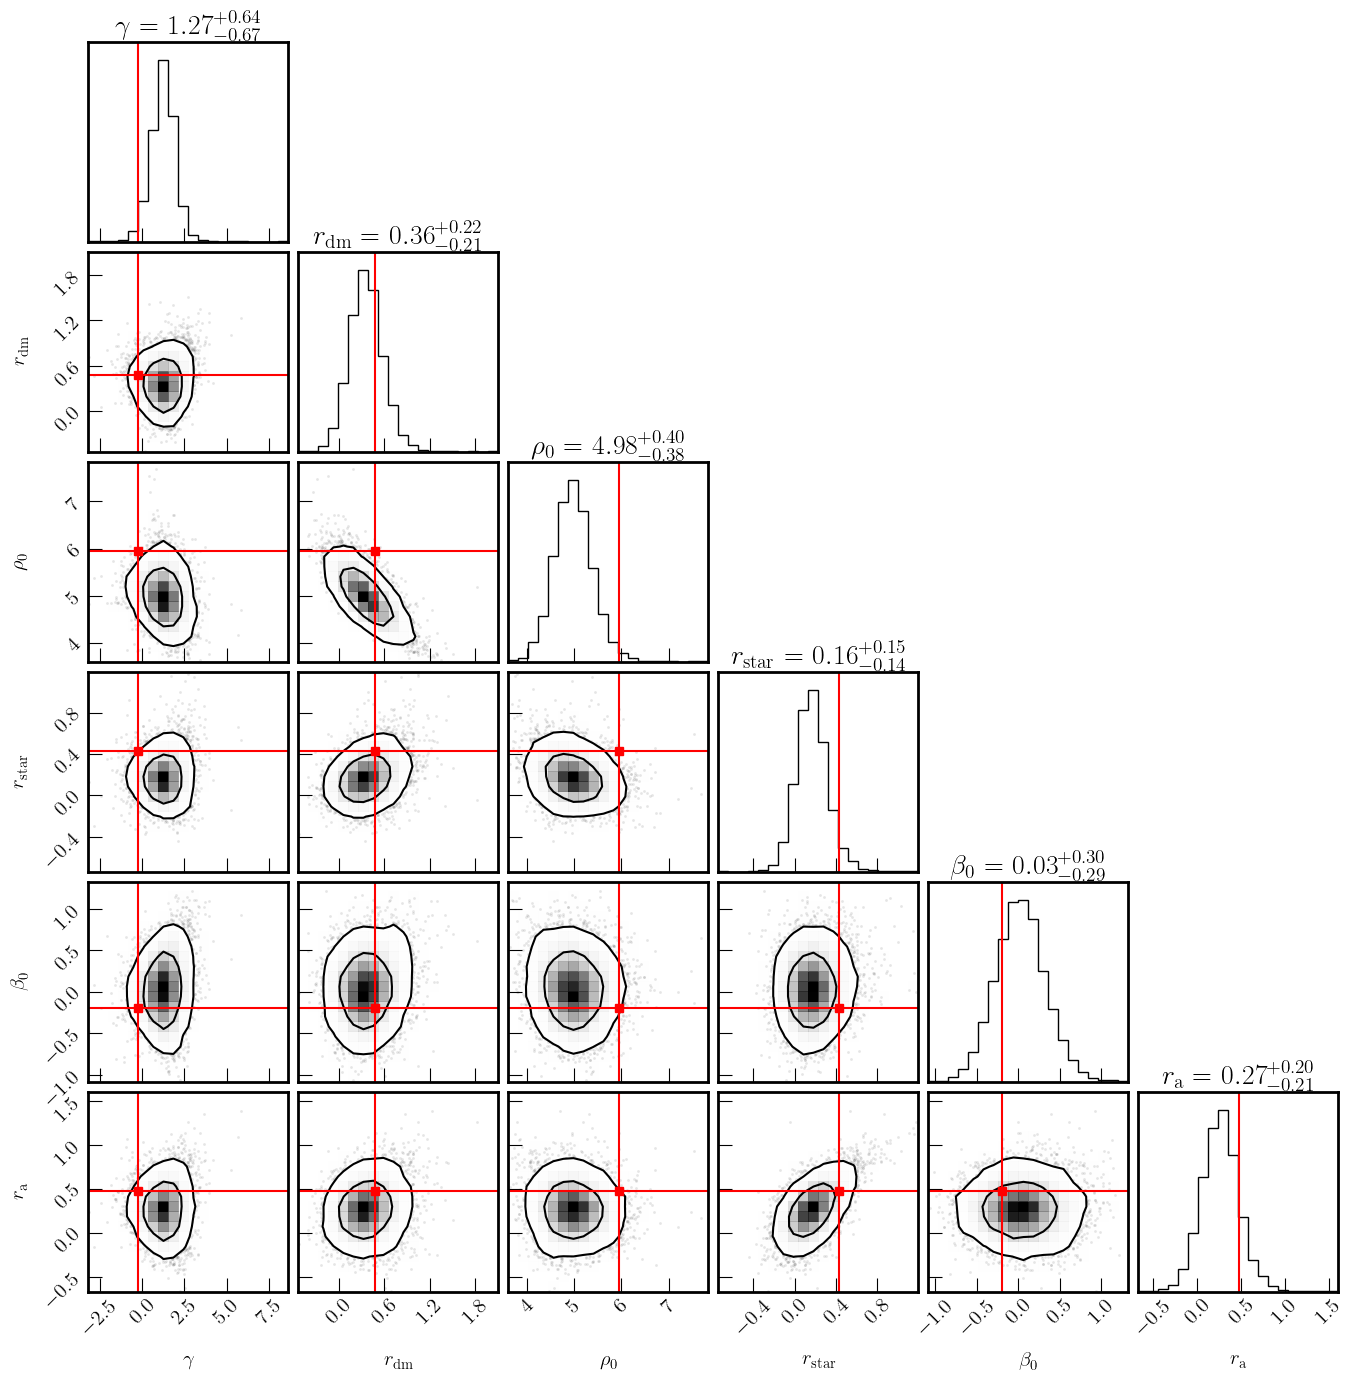

In [84]:
# plot corner plot of a chosen idx
idx = 6
labels = [
    r'$\gamma$', r'$r_{\rm dm}$', r'$\rho_0$', r'$r_{\rm star}$',
    r'$\beta_0$', r'$r_{\rm a}$'
]
corner_args =dict(
    truth_color='red',
    labels=labels,
    show_titles=True,
    title_kwargs={'fontsize': 20},
    smooth=0.5,
    levels=(0.68, 0.95),
)

fig = corner.corner(
    posteriors[idx], truths=truths[idx],
    **corner_args
)
